<a href="https://colab.research.google.com/github/wodamba-alt/Bottle-fill-yollo-11-training/blob/main/Training_with_R_CNN_on_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FINETUNING A R-CNN with ResNet backbone for object detection of COCOCOLA BOTTLES

In [1]:
!pip install roboflow
!pip install fiftyone
!pip install pycocotools


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

In [2]:
from roboflow import Roboflow

rf = Roboflow(api_key="O466H8chxDAKF7O5Yuil")
project = rf.workspace("davidbottle-defect-inspection").project("coco-cola-plastic-bottle-defects-dataset")
version = project.version(2)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...
Exporting format coco in progress : 85.0%
Version export complete for coco format



Extracting Dataset Version Zip to coco-cola-plastic-bottle-defects-dataset-2 in coco:: 100%|██████████| 5314/5314 [00:01<00:00, 4458.23it/s]


In [5]:
import os
import torch
from torch.utils.data import random_split, DataLoader
import torchvision
from torchvision.datasets import CocoDetection
import torchvision.transforms as T
import numpy as np

# Define paths
dataset_path = dataset.location
# Correct the path to the annotation file based on the Roboflow download structure
ann_file = os.path.join(dataset_path, "train", "_annotations.coco.json")
img_dir = os.path.join(dataset_path, "train")

# Define transforms
transform = T.Compose([
    T.ToTensor(),
])

# Load dataset
full_dataset = CocoDetection(img_dir, ann_file, transform=transform)

# Split dataset
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.22s)
creating index...
index created!


In [6]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = len(project.classes) + 1  # +1 for background

# Replace head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 186MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [7]:
import torch.optim as optim
from tqdm import tqdm

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epoch5 = 5
model.train()

for epoch in range(num_epoch=5):
    epoch_loss = 0
    for images, targets in tqdm(train_loader):
        images = list(img.to(device) for img in images)
        formatted_targets = []
        for i, t in enumerate(targets):
            boxes = torch.tensor([obj["bbox"] for obj in t], dtype=torch.float32)
            boxes[:, 2:] += boxes[:, :2]  # Convert [x, y, w, h] to [x1, y1, x2, y2]
            labels = torch.tensor([obj["category_id"] for obj in t], dtype=torch.int64)
            formatted_targets.append({"boxes": boxes.to(device), "labels": labels.to(device)})

        loss_dict = model(images, formatted_targets)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    lr_scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


100%|██████████| 1858/1858 [12:11<00:00,  2.54it/s]


Epoch 1/5, Loss: 324.8373


100%|██████████| 1858/1858 [12:14<00:00,  2.53it/s]


Epoch 2/5, Loss: 205.1997


100%|██████████| 1858/1858 [12:19<00:00,  2.51it/s]


Epoch 3/5, Loss: 183.0173


100%|██████████| 1858/1858 [12:30<00:00,  2.48it/s]


Epoch 4/5, Loss: 141.1800


100%|██████████| 1858/1858 [12:30<00:00,  2.47it/s]

Epoch 5/5, Loss: 133.6471


In [8]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import numpy as np

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, targets in tqdm(val_loader):
        images = list(img.to(device) for img in images)
        outputs = model(images)

        for i, output in enumerate(outputs):
            # Get predicted labels and their corresponding scores
            pred_labels = output["labels"].cpu().numpy()
            pred_scores = output["scores"].cpu().numpy()

            # Filter predictions based on a score threshold (e.g., 0.5)
            valid_indices = pred_scores > 0.5  # Adjust threshold as needed
            pred_labels = pred_labels[valid_indices]

            true_labels = [obj["category_id"] for obj in targets[i]]

            # Ensure both lists have the same length by taking the first element
            # of true_labels if it has more elements than pred_labels
            min_len = min(len(pred_labels), len(true_labels))
            all_preds.extend(pred_labels[:min_len])
            all_targets.extend(true_labels[:min_len])

# Confusion Matrix and Metrics
print("Confusion Matrix:\n", confusion_matrix(all_targets, all_preds))
print("Precision:", precision_score(all_targets, all_preds, average='macro'))
print("Recall:", recall_score(all_targets, all_preds, average='macro'))
print("F1 Score:", f1_score(all_targets, all_preds, average='macro'))
print("Accuracy:", accuracy_score(all_targets, all_preds))

100%|██████████| 929/929 [01:26<00:00, 10.71it/s]


Confusion Matrix:
 [[225  55  78   1 102]
 [ 58 162   4  37   0]
 [ 76   4 117 158   1]
 [  0  39 158 151 120]
 [102   1   0 119  87]]
Precision: 0.4082339315960725
Recall: 0.40832274511804006
F1 Score: 0.4082777659922411
Accuracy: 0.4


100%|██████████| 929/929 [01:26<00:00, 10.72it/s]


Confusion Matrix:
 [[225  55  78   1 102]
 [ 58 162   4  37   0]
 [ 76   4 117 158   1]
 [  0  39 158 151 120]
 [102   1   0 119  87]]
Precision: 0.4082
Recall:    0.4083
F1 Score:  0.4083
Accuracy:  0.4000


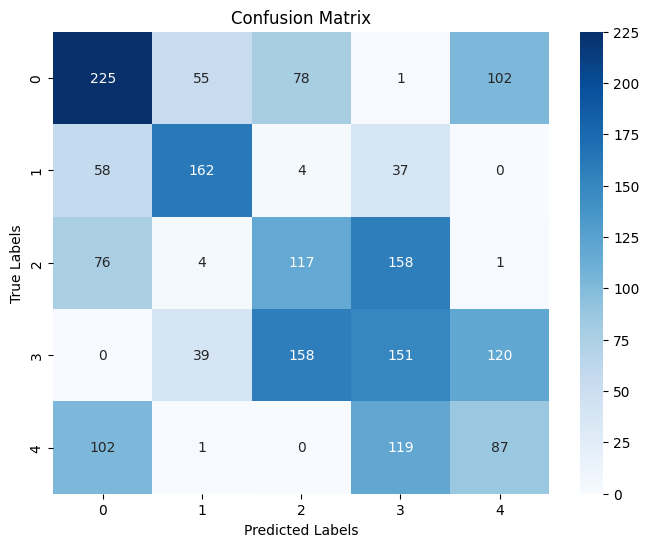

In [9]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Ensure model is in evaluation mode
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, targets in tqdm(val_loader):
        images = list(img.to(device) for img in images)
        outputs = model(images)

        for i, output in enumerate(outputs):
            # Get predicted labels and their corresponding scores
            pred_labels = output["labels"].cpu().numpy()
            pred_scores = output["scores"].cpu().numpy()

            # Filter predictions based on a score threshold (e.g., 0.5)
            valid_indices = pred_scores > 0.5  # Adjust threshold as needed
            pred_labels = pred_labels[valid_indices]

            # Extract true labels from the list of dictionaries
            true_labels = [obj["category_id"] for obj in targets[i]]

            # Ensure both lists have the same length by taking the first elements
            min_len = min(len(pred_labels), len(true_labels))
            all_preds.extend(pred_labels[:min_len])
            all_targets.extend(true_labels[:min_len])

# Compute confusion matrix and metrics
cm = confusion_matrix(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)
accuracy = accuracy_score(all_targets, all_preds)

print("Confusion Matrix:\n", cm)
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Accuracy:  {accuracy:.4f}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


100%|██████████| 929/929 [01:25<00:00, 10.86it/s]


Confusion Matrix:
 [[225  55  78   1 102]
 [ 58 162   4  37   0]
 [ 76   4 117 158   1]
 [  0  39 158 151 120]
 [102   1   0 119  87]]
Precision: 0.4082
Recall:    0.4083
F1 Score:  0.4083
Accuracy:  0.4000


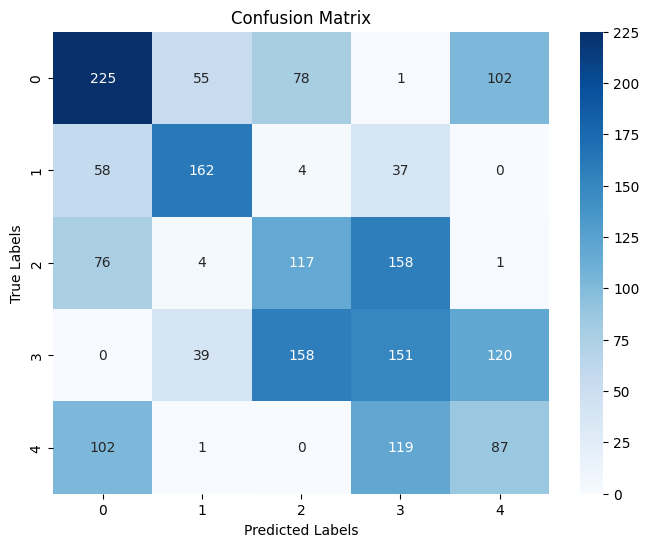

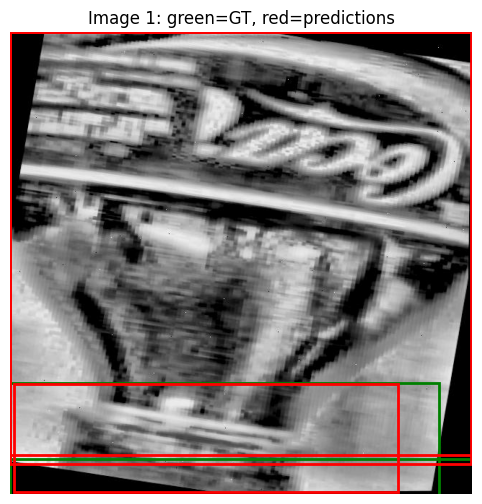

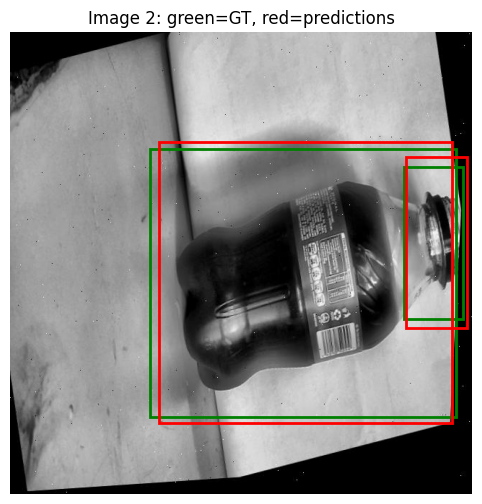

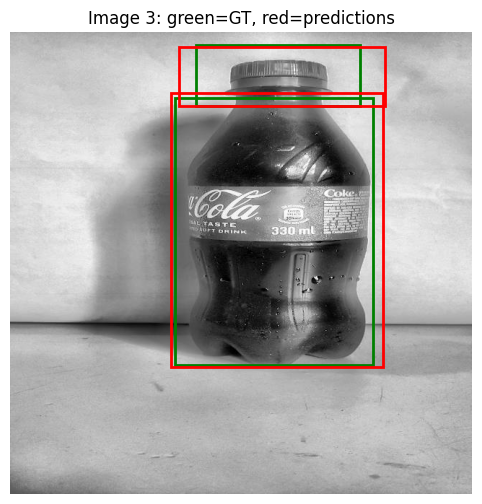

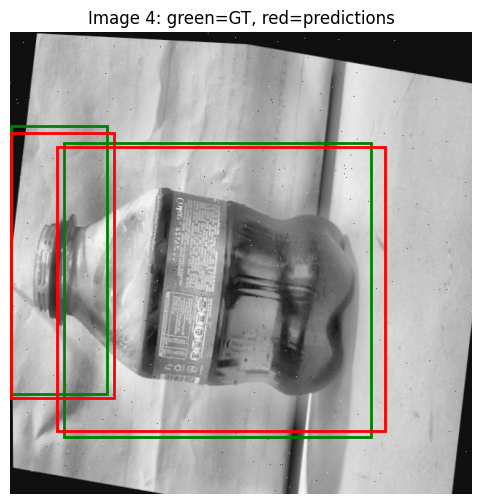

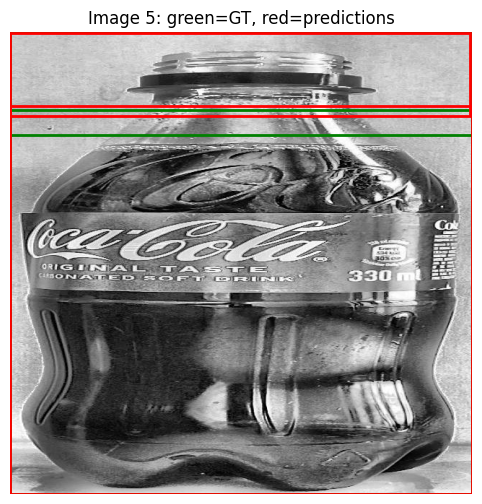

In [10]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from tqdm import tqdm

# --------------------------------------------
# (Your existing evaluation code…)
# --------------------------------------------

# Ensure model is in evaluation mode
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, targets in tqdm(val_loader):
        images = list(img.to(device) for img in images)
        outputs = model(images)

        for i, output in enumerate(outputs):
            # Get predicted labels and their corresponding scores
            pred_labels = output["labels"].cpu().numpy()
            pred_scores = output["scores"].cpu().numpy()

            # Filter predictions based on a score threshold (e.g., 0.5)
            valid_indices = pred_scores > 0.5  # Adjust threshold as needed
            pred_labels = pred_labels[valid_indices]

            # Extract true labels from the list of dictionaries
            true_labels = [obj["category_id"] for obj in targets[i]]

            # Ensure both lists have the same length by taking the first elements
            min_len = min(len(pred_labels), len(true_labels))
            all_preds.extend(pred_labels[:min_len])
            all_targets.extend(true_labels[:min_len])

# Compute confusion matrix and metrics
cm = confusion_matrix(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)
accuracy = accuracy_score(all_targets, all_preds)

print("Confusion Matrix:\n", cm)
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Accuracy:  {accuracy:.4f}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# --------------------------------------------
# Add this section to visualize a few images
# --------------------------------------------

# Number of validation images to display
num_images_to_display = 5
displayed = 0

# We’ll loop again over val_loader, run the model,
# and plot both ground‐truth and predicted boxes on each image.
with torch.no_grad():
    for images, targets in val_loader:
        images = list(img.to(device) for img in images)
        outputs = model(images)

        for i in range(len(images)):
            if displayed >= num_images_to_display:
                break

            # 1) Convert the tensor image to a NumPy array for plotting:
            img_tensor = images[i].cpu()
            # If your images were normalized during training, unnormalize here.
            # For example, if using mean/std = [0.485, 0.456, 0.406] & [0.229, 0.224, 0.225]:
            # mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
            # std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
            # img_tensor = img_tensor * std + mean

            img_np = img_tensor.permute(1, 2, 0).numpy()
            fig, ax = plt.subplots(1, figsize=(8, 6))
            ax.imshow(img_np)
            ax.axis('off')

            # 2) Plot ground‐truth boxes in green
            #    Each `targets[i]` is a list of dicts with keys "bbox" and "category_id".
            for obj in targets[i]:
                # Assuming `obj["bbox"]` is in COCO format: [xmin, ymin, width, height]
                xmin, ymin, width_box, height_box = obj["bbox"]
                rect = patches.Rectangle(
                    (xmin, ymin),
                    width_box,
                    height_box,
                    linewidth=2,
                    edgecolor='g',
                    facecolor='none'
                )
                ax.add_patch(rect)

            # 3) Plot predicted boxes (score > 0.5) in red
            pred_boxes = outputs[i]["boxes"].detach().cpu().numpy()
            pred_scores = outputs[i]["scores"].detach().cpu().numpy()
            for j, score in enumerate(pred_scores):
                if score < 0.5:
                    continue
                xmin, ymin, xmax, ymax = pred_boxes[j]
                rect = patches.Rectangle(
                    (xmin, ymin),
                    xmax - xmin,
                    ymax - ymin,
                    linewidth=2,
                    edgecolor='r',
                    facecolor='none'
                )
                ax.add_patch(rect)

            ax.set_title(f"Image {displayed+1}: green=GT, red=predictions")
            plt.show()

            displayed += 1

        if displayed >= num_images_to_display:
            break


100%|██████████| 929/929 [01:25<00:00, 10.88it/s]


Confusion Matrix:
 [[225  55  78   1 102]
 [ 58 162   4  37   0]
 [ 76   4 117 158   1]
 [  0  39 158 151 120]
 [102   1   0 119  87]]
Precision: 0.4082
Recall:    0.4083
F1 Score:  0.4083
Accuracy:  0.4000


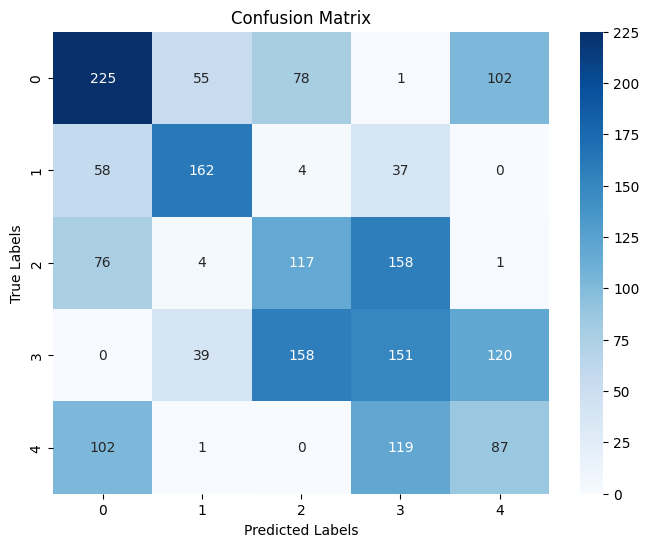

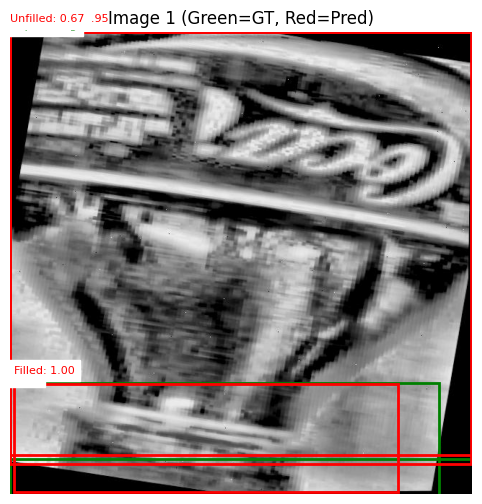

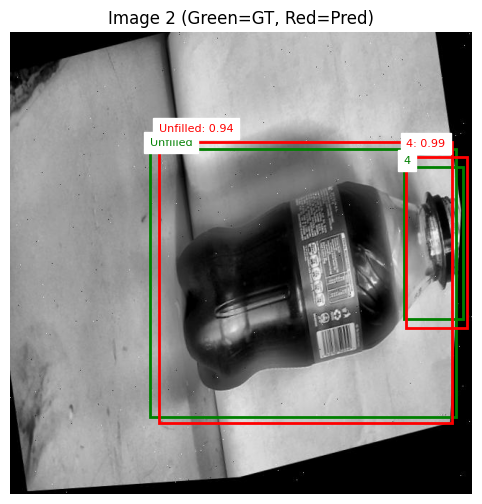

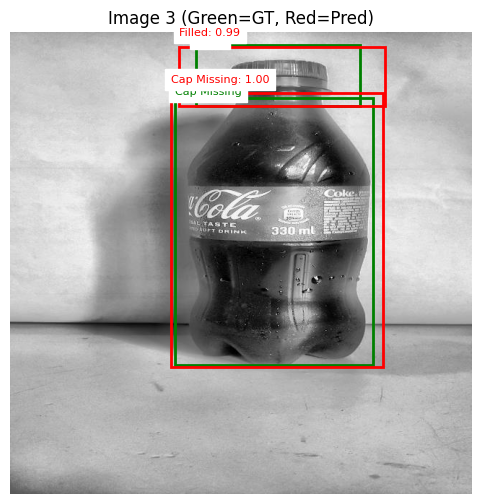

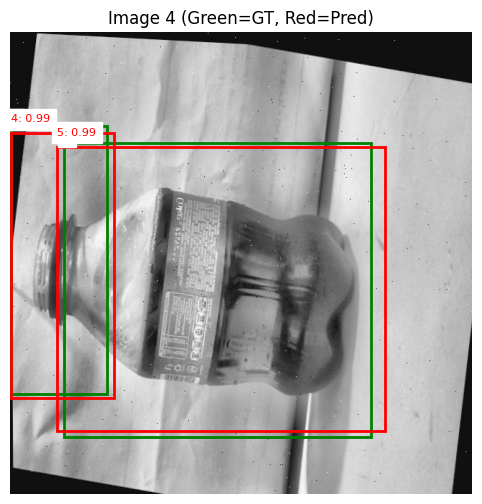

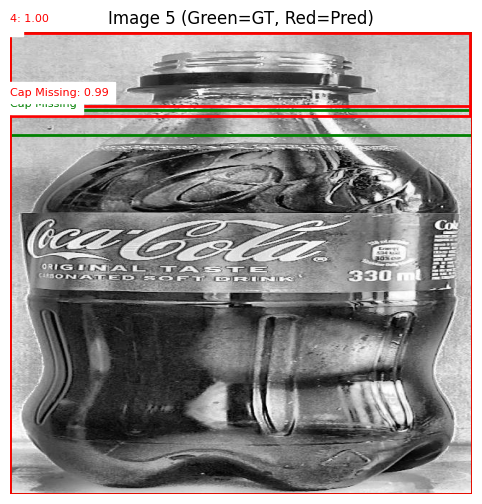

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from tqdm import tqdm
import seaborn as sns

# --------------------------------------------
# (Your existing evaluation code…)
# --------------------------------------------

# Ensure model is in evaluation mode
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, targets in tqdm(val_loader):
        images = list(img.to(device) for img in images)
        outputs = model(images)

        for i, output in enumerate(outputs):
            # Get predicted labels and their corresponding scores
            pred_labels = output["labels"].cpu().numpy()
            pred_scores = output["scores"].cpu().numpy()

            # Filter predictions based on a score threshold (e.g., 0.5)
            valid_indices = pred_scores > 0.5  # Adjust threshold as needed
            pred_labels = pred_labels[valid_indices]

            # Extract true labels from the list of dictionaries
            true_labels = [obj["category_id"] for obj in targets[i]]

            # Ensure both lists have the same length by taking the first elements
            min_len = min(len(pred_labels), len(true_labels))
            all_preds.extend(pred_labels[:min_len])
            all_targets.extend(true_labels[:min_len])

# Compute confusion matrix and metrics
cm = confusion_matrix(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)
accuracy = accuracy_score(all_targets, all_preds)

print("Confusion Matrix:\n", cm)
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Accuracy:  {accuracy:.4f}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# --------------------------------------------
# (NEW SECTION STARTS HERE)
# --------------------------------------------

# 0) Define your mapping from category_id → class name:
#    Replace these keys/values with your actual dataset’s IDs and names.
id2label = {
    1: "Filled",
    2: "Unfilled",
    3: "Cap Missing",
    # …etc.
}

# --------------------------------------------
# 1) VISUALIZE A FEW VALIDATION IMAGES WITH CLASS NAMES
# --------------------------------------------
num_images_to_display = 5
displayed = 0

model.eval()
with torch.no_grad():
    for images, targets in val_loader:
        images = list(img.to(device) for img in images)
        outputs = model(images)

        for i in range(len(images)):
            if displayed >= num_images_to_display:
                break

            # Convert tensor image to NumPy (unnormalize if needed)
            img_tensor = images[i].cpu()
            # If your images were normalized (e.g. ImageNet mean/std), unnormalize here:
            #   mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
            #   std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
            #   img_tensor = img_tensor * std + mean

            img_np = img_tensor.permute(1, 2, 0).numpy()
            fig, ax = plt.subplots(1, figsize=(8, 6))
            ax.imshow(img_np)
            ax.axis("off")

            # Plot ground-truth boxes in green with class names
            for obj in targets[i]:
                xmin, ymin, width_box, height_box = obj["bbox"]
                gt_id = obj["category_id"]
                gt_name = id2label.get(gt_id, str(gt_id))
                rect = patches.Rectangle(
                    (xmin, ymin),
                    width_box,
                    height_box,
                    linewidth=2,
                    edgecolor="g",
                    facecolor="none",
                )
                ax.add_patch(rect)
                ax.text(
                    xmin,
                    ymin - 5,
                    gt_name,
                    color="g",
                    fontsize=8,
                    backgroundcolor="white",
                )

            # Plot predicted boxes (score > 0.5) in red with class names
            pred_boxes = outputs[i]["boxes"].cpu().numpy()
            pred_labels = outputs[i]["labels"].cpu().numpy()
            pred_scores = outputs[i]["scores"].cpu().numpy()

            for j, score in enumerate(pred_scores):
                if score < 0.5:
                    continue
                xmin, ymin, xmax, ymax = pred_boxes[j]
                pred_id = int(pred_labels[j])
                pred_name = id2label.get(pred_id, str(pred_id))
                rect = patches.Rectangle(
                    (xmin, ymin),
                    xmax - xmin,
                    ymax - ymin,
                    linewidth=2,
                    edgecolor="r",
                    facecolor="none",
                )
                ax.add_patch(rect)
                ax.text(
                    xmin,
                    ymin - 15,
                    f"{pred_name}: {score:.2f}",
                    color="r",
                    fontsize=8,
                    backgroundcolor="white",
                )

            ax.set_title(f"Image {displayed + 1} (Green=GT, Red=Pred)")
            plt.show()

            displayed += 1

        if displayed >= num_images_to_display:
            break

# --------------------------------------------
# 2) PRECISION & RECALL vs. CONFIDENCE THRESHOLD
# --------------------------------------------

# We'll evaluate at thresholds from 0.0 to 1.0 in steps of 0.05
thresholds = np.arange(0.0, 1.01, 0.05)
precision_list = []
recall_list = []
all_scores = []

for t in thresholds:
    model.eval()
    preds_t = []
    targets_t = []

    with torch.no_grad():
        for images, targets in val_loader:
            images = list(img.to(device) for img in images)
            outputs = model(images)

            for i in range(len(images)):
                # Get predicted labels and scores
                pred_labels = outputs[i]["labels"].cpu().numpy()
                pred_scores = outputs[i]["scores"].cpu().numpy()

                # On the first threshold pass (t == 0.0), collect all scores for histogram
                if t == 0.0:
                    all_scores.extend(pred_scores.tolist())

                # Filter predictions by current threshold t
                valid_idx = pred_scores > t
                pred_labels_t = pred_labels[valid_idx]

                # True labels for this image
                true_labels = [obj["category_id"] for obj in targets[i]]

                # Align by taking only up to the smaller length
                min_len = min(len(pred_labels_t), len(true_labels))
                if min_len > 0:
                    preds_t.extend(pred_labels_t[:min_len].tolist())
                    targets_t.extend(true_labels[:min_len])

    # If there were no predictions above threshold, set metrics to 0.0
    if len(preds_t) == 0:
        precision_list.append(0.0)
        recall_list.append(0.0)
    else:
        precision_list.append(
            precision_score(targets_t, preds_t, average="macro", zero_division=0)
        )
        recall_list.append(
            recall_score(targets_t, preds_t, average="macro", zero_division=0)
        )

# Plot Precision vs. Confidence Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision_list, marker="o")
plt.xlabel("Confidence Threshold")
plt.ylabel("Precision (macro)")
plt.title("Precision vs. Confidence Threshold")
plt.grid(True)
plt.show()

# Plot Recall vs. Confidence Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, recall_list, marker="o")
plt.xlabel("Confidence Threshold")
plt.ylabel("Recall (macro)")
plt.title("Recall vs. Confidence Threshold")
plt.grid(True)
plt.show()

# --------------------------------------------
# 3) CONFIDENCE SCORES HISTOGRAM
# --------------------------------------------
plt.figure(figsize=(8, 5))
plt.hist(all_scores, bins=20)
plt.xlabel("Predicted Confidence Scores")
plt.ylabel("Frequency")
plt.title("Histogram of Prediction Confidence Scores")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from sklearn.metrics import precision_score, recall_score
from tqdm import tqdm

# ------------------------------------------------
# Assumed existing above: `model`, `device`, `val_loader`
# ------------------------------------------------

# 0) Replace with your actual mapping from category_id → class name
id2label = {
    1: "Filled",
    2: "Unfilled",
    3: "Cap Missing",
    # …etc.
}

# If you used torchvision.transforms.Normalize with these mean/std, keep them here:
imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
imagenet_std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

# --------------------------------------------
# VISUALIZE A FEW VALIDATION IMAGES IN COLOR
# --------------------------------------------
num_images_to_display = 5
displayed = 0

model.eval()
with torch.no_grad():
    for images, targets in val_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for i in range(len(images)):
            if displayed >= num_images_to_display:
                break

            # 1) Unnormalize & convert to NumPy in [0,1] for plotting
            img_tensor = images[i].cpu().clone()
            # If your pipeline applied Normalize(mean,std), unnormalize here:
            img_tensor = img_tensor * imagenet_std + imagenet_mean
            # Clip to [0,1] just in case
            img_tensor = torch.clamp(img_tensor, 0.0, 1.0)

            img_np = img_tensor.permute(1, 2, 0).numpy()  # H x W x 3 in [0,1]
            fig, ax = plt.subplots(1, figsize=(8, 6))
            ax.imshow(img_np)
            ax.axis("off")

            # 2) Draw ground-truth boxes (green) with class names
            for obj in targets[i]:
                xmin, ymin, width_box, height_box = obj["bbox"]
                gt_id = obj["category_id"]
                gt_name = id2label.get(gt_id, str(gt_id))

                rect = patches.Rectangle(
                    (xmin, ymin),
                    width_box,
                    height_box,
                    linewidth=2,
                    edgecolor="g",
                    facecolor="none"
                )
                ax.add_patch(rect)
                ax.text(
                    xmin,
                    ymin - 5,
                    gt_name,
                    color="g",
                    fontsize=8,
                    backgroundcolor="white"
                )

            # 3) Draw predicted boxes (red) with class names + confidence
            pred_boxes = outputs[i]["boxes"].cpu().numpy()         # (N,4)
            pred_labels = outputs[i]["labels"].cpu().numpy()       # (N,)
            pred_scores = outputs[i]["scores"].cpu().numpy()       # (N,)

            for j, score in enumerate(pred_scores):
                if score < 0.5:  # only show predictions with confidence > 0.5
                    continue

                xmin, ymin, xmax, ymax = pred_boxes[j]
                pred_id = int(pred_labels[j])
                pred_name = id2label.get(pred_id, str(pred_id))

                rect = patches.Rectangle(
                    (xmin, ymin),
                    xmax - xmin,
                    ymax - ymin,
                    linewidth=2,
                    edgecolor="r",
                    facecolor="none"
                )
                ax.add_patch(rect)

                # Place "<class>: <conf>" just above the box
                ax.text(
                    xmin,
                    ymin - 15,
                    f"{pred_name}: {score:.2f}",
                    color="r",
                    fontsize=8,
                    backgroundcolor="white"
                )

            ax.set_title(f"Image {displayed + 1} (Green=GT, Red=Pred)")
            plt.show()

            displayed += 1

        if displayed >= num_images_to_display:
            break
